# Statistical models in R
This notebook is covering:
1. Test predict method for TVECM

In [19]:
import pandas as pd
import plotly.express as px
import plotly.graph_objs as go

In [20]:
# rpy2 is a Python package that allows you to run R code from Python
%pip install rpy2

Note: you may need to restart the kernel to use updated packages.


In [21]:
# Load the rpy2 extension to use R in Jupyter
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


The magic function `%%R` is used for running R code in Jupyter

In [22]:
%%R
# Install required packages
if (require("dplyr") == FALSE) {
  install.packages("dplyr")
  library(dplyr)
}
if (require("zoo") == FALSE) {
  install.packages("zoo")
  library(zoo)
}

if (require("forecast") == FALSE) {
  install.packages("forecast")
  library(forecast)
}
if (require("tseries") == FALSE) {
  install.packages("tseries")
  library(tseries)
}
if (require("moments") == FALSE) {
  install.packages("moments")
  library(moments)
}
if (require("tibble") == FALSE) {
  install.packages("tibble")
  library(tibble)
}
if (require("urca") == FALSE) {
  install.packages("urca")
  library(urca)
}
if (require("kableExtra") == FALSE) {
  install.packages("kableExtra")
  library(kableExtra)
}
if (require("rugarch") == FALSE) {
  install.packages("rugarch")
  library(rugarch)
}



In [23]:
%%R
# Load data
hub_prices <- list(
  nbp = read.csv("../../data/interpolated/nbp_close_interpolated.csv"),
  peg = read.csv("../../data/interpolated/peg_close_interpolated.csv"),
  the = read.csv("../../data/interpolated/the_close_interpolated.csv"),
  ttf = read.csv("../../data/interpolated/ttf_close_interpolated.csv"),
  ztp = read.csv("../../data/interpolated/ztp_close_interpolated.csv")
)

In [24]:
%%R

hub1_name <- "ttf"
hub2_name <- "nbp"

hub1 <- hub_prices[[hub1_name]]
hub2 <- hub_prices[[hub2_name]]

hubs <- data.frame(hub1 = hub1$CLOSE, hub2 = hub2$CLOSE)

In [25]:
%%R
validation_size <- 250
test_size <- 250
window_size <- 5


In [26]:
%%R
start <- 1
end <- nrow(hubs) - window_size
return_start <- window_size + 1
return_end <- nrow(hubs)

hub1_historical_returns <- log(hubs[return_start:return_end, 1] / hubs[start:end, 1])
hub2_historical_returns <- log(hubs[return_start:return_end, 2] / hubs[start:end, 2])

returns_difference <- hub1_historical_returns - hub2_historical_returns


In [27]:
%%R
train_size <- length(returns_difference) - test_size - window_size + 1
    returns_difference_train <- returns_difference[1:train_size]

In [28]:
%%R
tail(returns_difference_train,10)


 [1] -0.004407768  0.011567259  0.024881875  0.020107900 -0.066859966
 [6]  0.026634835  0.028589306  0.010718891 -0.006998791 -0.028622390


In [29]:
%%R
length(returns_difference_train)

[1] 1286


In [30]:
%%R
tail(returns_difference_train, 1)

[1] -0.02862239


In [31]:
%%R

tail(returns_difference, 255)

  [1] -2.862239e-02 -2.550741e-02 -3.275865e-02 -3.492005e-02 -2.518842e-02
  [6] -9.345885e-03 -1.365590e-02 -1.485965e-02 -1.228024e-02 -4.483326e-03
 [11]  5.583187e-03  1.259216e-02  1.314521e-02  1.715704e-02  1.422896e-02
 [16]  1.342380e-02  1.313586e-02  1.368708e-02  1.634228e-02  1.782864e-02
 [21]  1.914637e-03 -1.510183e-02 -1.790221e-02 -1.879205e-02 -2.532965e-02
 [26] -4.563266e-03  1.615819e-02  2.873299e-02  3.310288e-02  3.275071e-02
 [31]  1.904091e-02  9.646370e-03  1.361511e-04 -7.934141e-03 -7.460552e-03
 [36] -2.155642e-02 -4.207334e-02 -3.157570e-02 -3.245732e-02 -3.020455e-02
 [41] -6.957204e-03  2.029848e-02  1.133296e-02  1.308261e-02  1.830585e-02
 [46]  1.757899e-02  1.217482e-02  1.139242e-02  8.805236e-03  2.803984e-03
 [51] -1.087881e-02 -1.443915e-02 -1.037491e-02 -2.102631e-02 -2.720187e-02
 [56] -1.391174e-02 -6.201725e-03 -9.403605e-03 -3.161807e-03  5.961282e-03
 [61]  4.323454e-03  6.378067e-03  6.753437e-03  1.152627e-02  4.314385e-03
 [66]  5.562

In [32]:
%%R
length(returns_difference)

[1] 1540


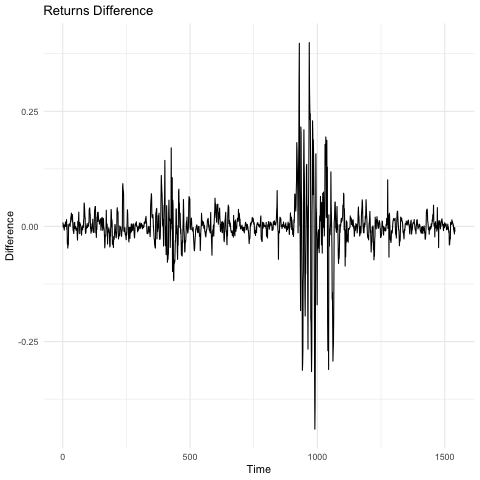

In [33]:
%%R
library(ggplot2)

ggplot(data.frame(returns_difference), aes(x = seq_along(returns_difference), y = returns_difference)) +
    geom_line() +
    labs(title = "Returns Difference", x = "Time", y = "Difference") +
    theme_minimal()

In [34]:
%%R
ljung_box_test <- Box.test(returns_difference, lag = 5, type = "Ljung-Box")
kpss_test <- kpss.test(returns_difference)
adf_test <- adf.test(returns_difference, k = 5)

In addition: Warning messages:
1: In kpss.test(returns_difference) : p-value greater than printed p-value
2: In adf.test(returns_difference, k = 5) :
  p-value smaller than printed p-value


In [35]:
%%R
arma_model <- auto.arima(returns_difference, seasonal = FALSE)
summary(arma_model)

Series: returns_difference 
ARIMA(5,0,1) with zero mean 

Coefficients:
         ar1     ar2     ar3      ar4      ar5     ma1
      0.2659  0.3731  0.0137  -0.0326  -0.3493  0.5217
s.e.  0.0445  0.0399  0.0265   0.0251   0.0240  0.0422

sigma^2 = 0.001078:  log likelihood = 3078.06
AIC=-6142.11   AICc=-6142.04   BIC=-6104.74

Training set error measures:
                       ME       RMSE       MAE      MPE     MAPE      MASE
Training set 0.0001177295 0.03277142 0.0161749 116.6571 275.3023 0.8850174
                   ACF1
Training set 0.04500286


In [36]:
%%R

# Step 1: Fit the ARMA model
arma_model <- auto.arima(returns_difference, seasonal = FALSE)

# Step 2: Specify the GARCH model with ARMA mean
spec <- ugarchspec(
  variance.model = list(model = "gjrGARCH",garchOrder = c(1, 1)),
  mean.model = list(armaOrder = c(arma_model$arma[1], arma_model$arma[2]), include.mean = TRUE),
  distribution.model = "sstd"
)

# Step 3: Fit the GARCH model
garch_fit <- ugarchfit(spec = spec, data = returns_difference)

# Display the results
print(garch_fit)



*---------------------------------*
*          GARCH Model Fit        *
*---------------------------------*

Conditional Variance Dynamics 	
-----------------------------------
GARCH Model	: gjrGARCH(1,1)
Mean Model	: ARFIMA(5,0,1)
Distribution	: sstd 

Optimal Parameters
------------------------------------
        Estimate  Std. Error  t value Pr(>|t|)
mu      0.000864    0.000721   1.1980 0.230903
ar1     0.313071    0.038303   8.1735 0.000000
ar2     0.356654    0.033377  10.6857 0.000000
ar3     0.062703    0.025746   2.4355 0.014871
ar4     0.086798    0.023455   3.7006 0.000215
ar5    -0.364433    0.022533 -16.1731 0.000000
ma1     0.429107    0.036152  11.8694 0.000000
omega   0.000008    0.000002   3.4096 0.000651
alpha1  0.276017    0.042759   6.4552 0.000000
beta1   0.771959    0.028085  27.4863 0.000000
gamma1 -0.093839    0.049699  -1.8881 0.059008
skew    1.093838    0.035289  30.9968 0.000000
shape   4.020877    0.393490  10.2185 0.000000

Robust Standard Errors:
      

In [39]:
%%R
# Step 4: Forecast the volatility
garch_forecast <- ugarchforecast(garch_fit, n.ahead = window_size)


In [40]:
%%R
garch_forecast@forecast$sigmaFor[window_size, , drop = FALSE]

    1974-03-21
T+5 0.01188118


In [41]:
%%R
sigma_values <- sigma(garch_fit)
sigma_df <- data.frame(Date = hub1[return_start:return_end, ][["Date"]], Sigma = sigma_values)
rownames(sigma_df) <- seq_along(sigma_values)


In [43]:
%%R
sigma_values <- sigma(garch_fit)

In [46]:
%%R
sigma_values[length(sigma_values)]

                [,1]
1974-03-21 0.0101221


R[write to console]: In addition: 
R[write to console]: Warning message:

R[write to console]: object timezone ('UTC') is different from system timezone ('') 



In [42]:
%%R
sigma_df

           Date       Sigma
1    2018-10-08 0.033479999
2    2018-10-09 0.033479999
3    2018-10-10 0.033479999
4    2018-10-11 0.033479999
5    2018-10-12 0.033479999
6    2018-10-15 0.029599567
7    2018-10-16 0.026189932
8    2018-10-17 0.023435875
9    2018-10-18 0.020781526
10   2018-10-19 0.018565075
11   2018-10-22 0.016576029
12   2018-10-23 0.014883930
13   2018-10-24 0.013622447
14   2018-10-25 0.012443951
15   2018-10-26 0.011362946
16   2018-10-29 0.012943053
17   2018-10-30 0.013420102
18   2018-10-31 0.012576604
19   2018-11-01 0.019881744
20   2018-11-02 0.018512727
21   2018-11-05 0.017175046
22   2018-11-06 0.015502275
23   2018-11-07 0.014512931
24   2018-11-08 0.015925481
25   2018-11-09 0.014387055
26   2018-11-12 0.013841794
27   2018-11-13 0.012520442
28   2018-11-14 0.012248103
29   2018-11-15 0.011341774
30   2018-11-16 0.010513728
31   2018-11-19 0.010973005
32   2018-11-20 0.010602251
33   2018-11-21 0.011400441
34   2018-11-22 0.010924228
35   2018-11-23 0.01

In [63]:
%%R
hub1[1:3, ]

        Date  CLOSE
1 2018-10-01 27.443
2 2018-10-02 27.257
3 2018-10-03 27.114


In [64]:
%%R
tail(sigma_values,1)

                [,1]
1974-03-21 0.0101221


R[write to console]: In addition: 
R[write to console]: Warning message:

R[write to console]: object timezone ('UTC') is different from system timezone ('') 

